In [1]:
import cv2
import glob
from skimage.feature import hog
import numpy as np
import time
import matplotlib.image as mpimg
from sklearn.svm import LinearSVC

def colour_hist(img, nbins = 32):
    channel1_hist = np.histogram(img[:,:,0], bins = nbins)
    channel2_hist = np.histogram(img[:,:,1], bins = nbins)
    channel3_hist = np.histogram(img[:,:,2], bins = nbins)

    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def get_features_all(images):
    features = []
    
    for fname in images:
        img = mpimg.imread(fname)

        f = get_features_img(img)

        features.append(f)
    
    return features

def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

def conv_colour(img):
    # YUV - Test Accuracy of SVC =  0.991
    # YCrCb - Test Accuracy of SVC =  0.9947


    #return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

def get_features_img(img):
    #feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    feature_img = conv_colour(img)
    
    hog_features = []
    
    for i in range(3):
        hog_features.append(hog(feature_img[:,:,i], orientations=orient,
                  pixels_per_cell = (pix_per_cell, pix_per_cell), 
                  cells_per_block = (cell_per_block, cell_per_block), 
                  visualise = False, feature_vector = True))
        
    hog_features = np.ravel(hog_features) 
    
    f = np.concatenate((hog_features, colour_hist(feature_img), bin_spatial(feature_img)))
    return f

In [2]:
vehicles = glob.glob('./vehicles/*/*.png')
non_vehicles = glob.glob('./non-vehicles/*/*.png')

n_samples = 2000
random_idxs = np.random.randint(0, len(vehicles), n_samples)
vehicles_subset = vehicles #np.array(vehicles)[random_idxs]
non_vehicles_subset = non_vehicles #np.array(non_vehicles)[random_idxs]

features = []
labels = []

pix_per_cell = 8
cell_per_block = 2
orient = 9

t = time.time()

vehicle_features = get_features_all(vehicles_subset)
non_vehicle_features = get_features_all(non_vehicles_subset)

t2 = time.time()
print(round(t2 - t, 2), 'Seconds to extract features...')

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

# Normalise feature space

X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)                        

# Fit a per-column scaler

X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector

y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

# Split up data into randomized training and test sets

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size = 0.2, random_state = rand_state)

print('Using:', orient,'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

t = time.time()

from sklearn.svm import SVC

#parameters = {'C': [1, 10]}
#svr = svm.SVC()
#clf = grid_search.GridSearchCV(svr, parameters)
#clf = SVC(kernel = "rbf")
clf = LinearSVC() #SVC(kernel = "rbf")
clf.fit(X_train, y_train)

t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')

t=time.time()

pred = clf.predict(X_test)

t2 = time.time()
print(round(t2 - t, 5), 'Seconds to predict with SVC')

from sklearn.metrics import accuracy_score
acc = accuracy_score(pred, y_test)

print('Test Accuracy of SVC = ', round(acc, 4))

/Users/vctr/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


94.74 Seconds to extract features...


/Users/vctr/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
20.58 Seconds to train SVC...
0.24399 Seconds to predict with SVC
Test Accuracy of SVC =  0.9916


/Users/vctr/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


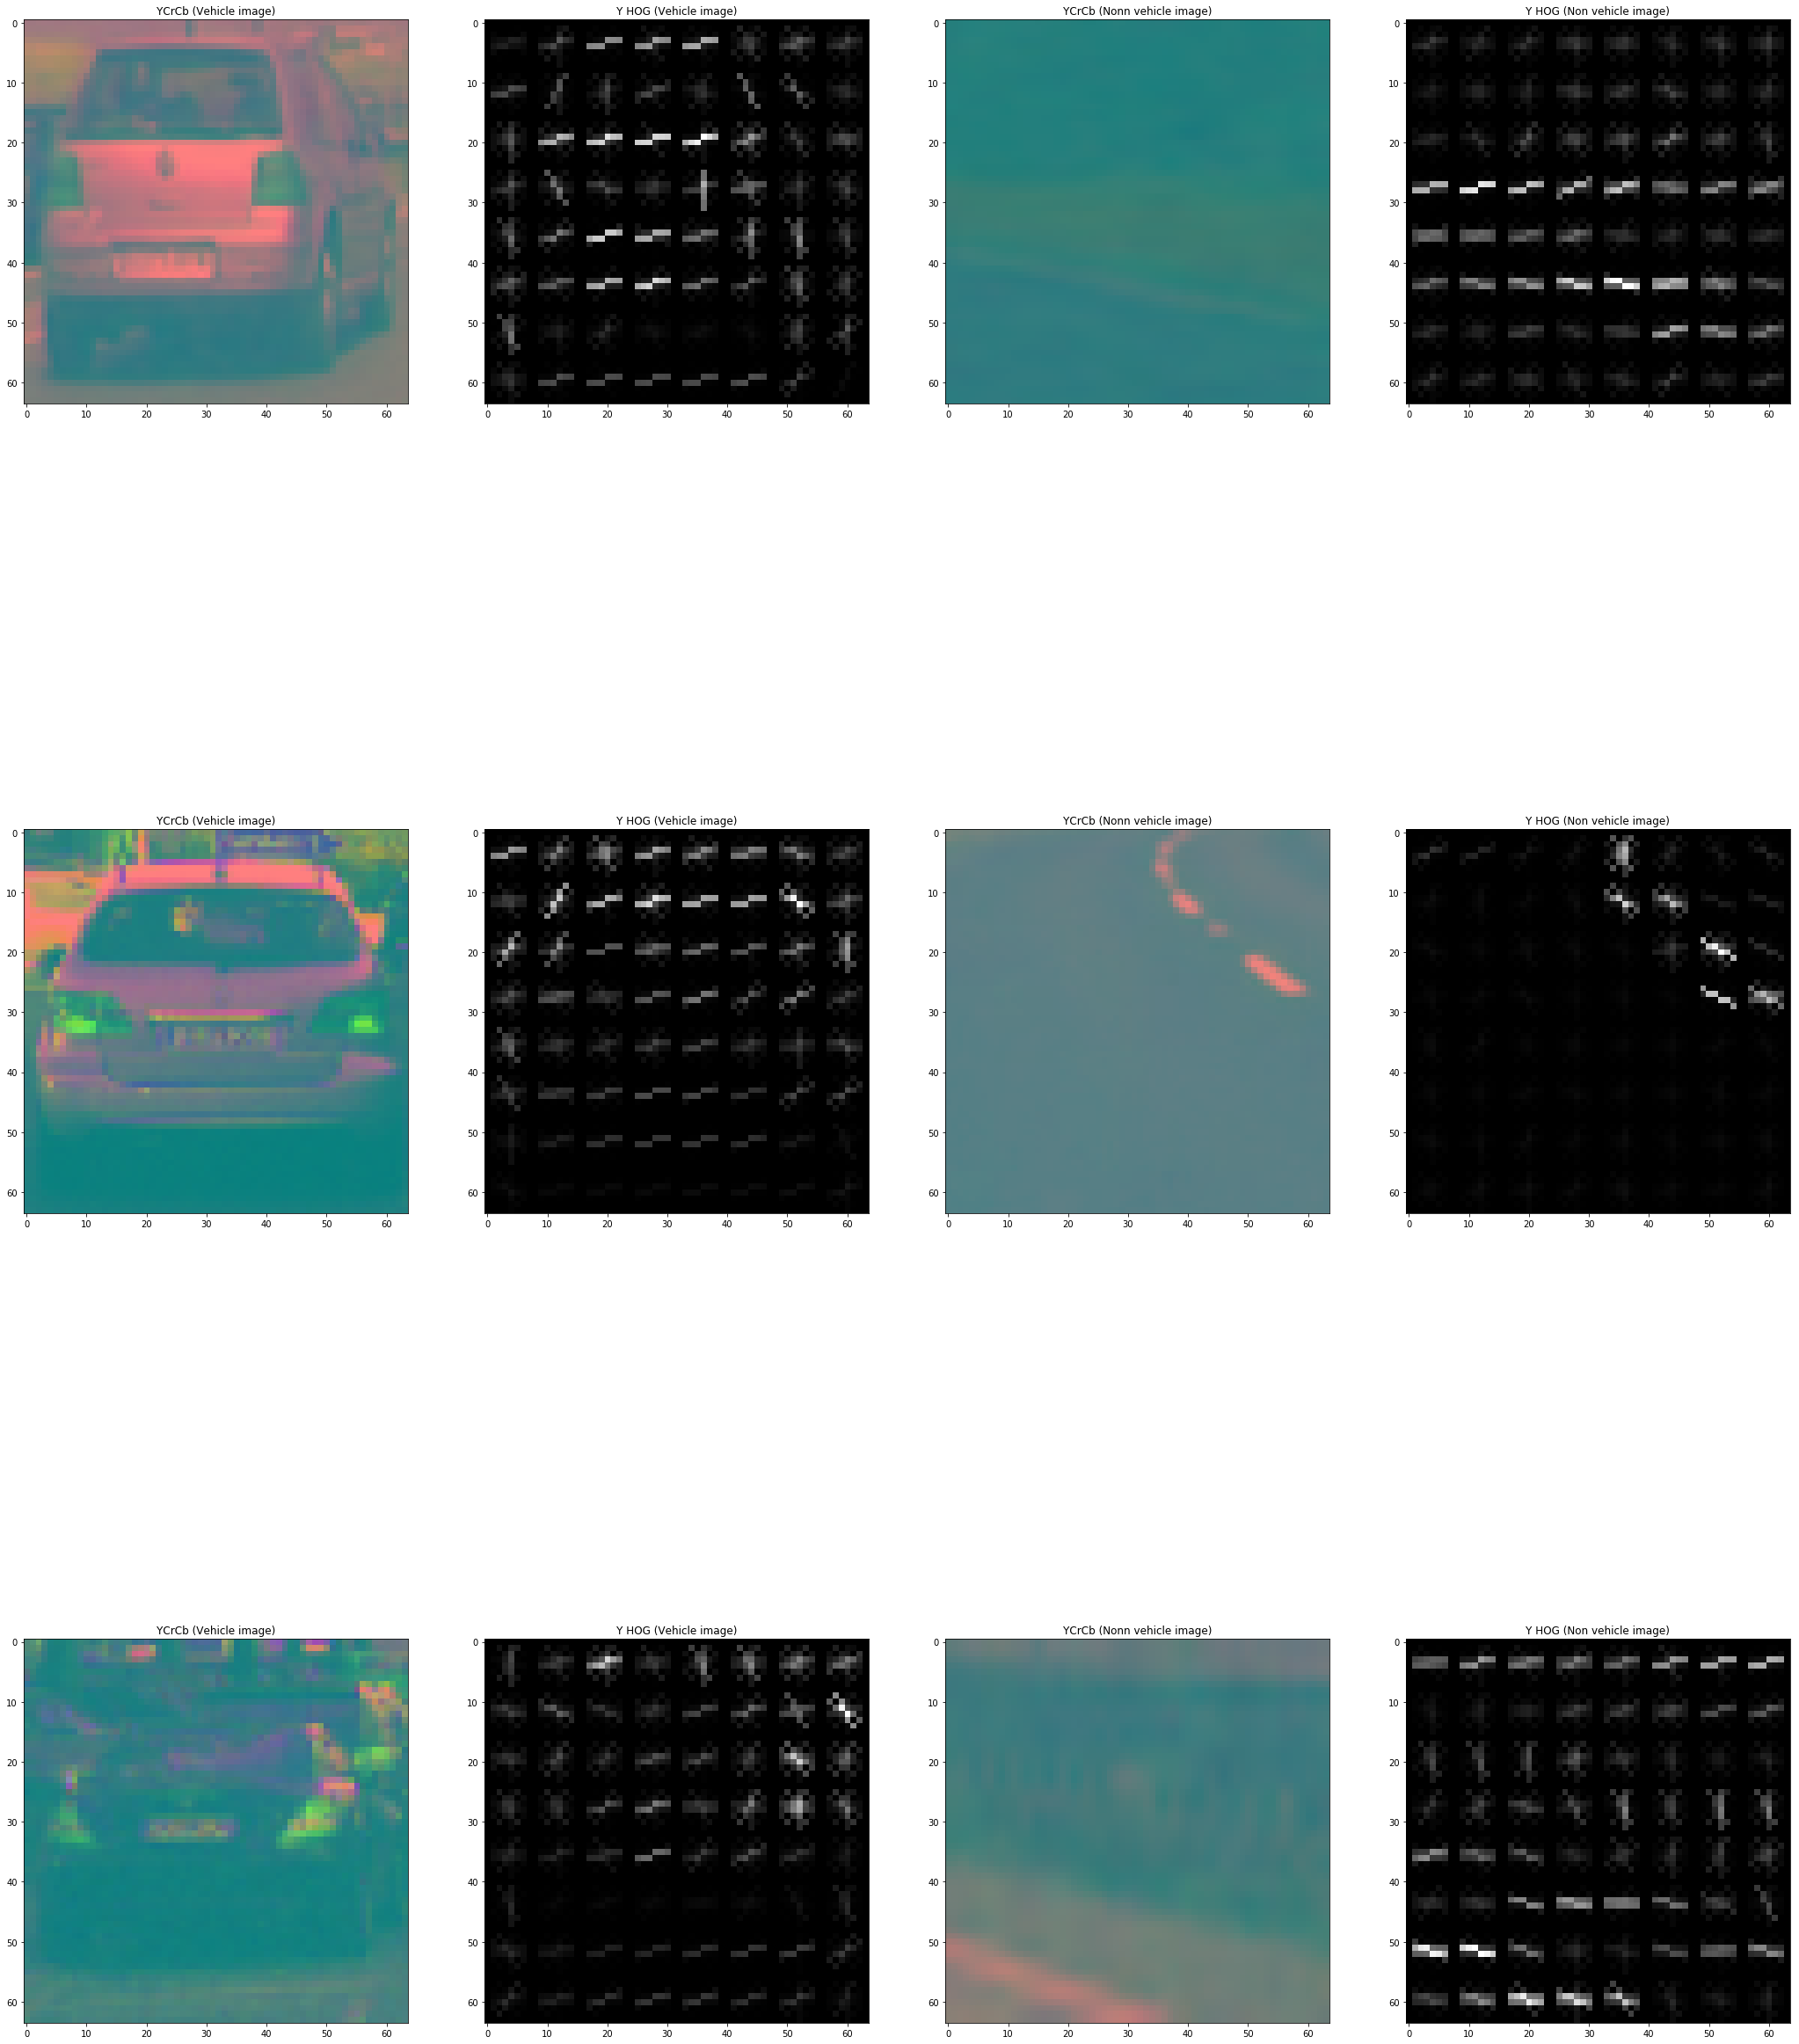

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline

vehicles = glob.glob('./vehicles/*/*.png')
non_vehicles = glob.glob('./non-vehicles/*/*.png')

n_samples = 3
random_idxs = np.random.randint(0, len(vehicles), n_samples)
vehicles_subset = np.array(vehicles)[random_idxs]
non_vehicles_subset = np.array(non_vehicles)[random_idxs]

images = glob.glob('./test_images/*.jpg')

plt.figure(figsize=(36, 48))
    
for i in range(n_samples):
    img = mpimg.imread(vehicles_subset[i])
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    
    plt.subplot(n_samples, 4, i * 4 + 1)
    plt.imshow(img)
    plt.title('YCrCb (Vehicle image)')
    
    plt.subplot(n_samples, 4, i * 4 + 2)
        
    features, hog_img = hog(img[:,:,0], orientations=orient,
                  pixels_per_cell = (pix_per_cell, pix_per_cell), 
                  cells_per_block = (cell_per_block, cell_per_block), 
                  visualise = True, feature_vector = True)

    plt.imshow(hog_img, cmap = 'gray')
    plt.title('Y HOG (Vehicle image)')
    
    img = mpimg.imread(non_vehicles_subset[i])
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    
    plt.subplot(n_samples, 4, i * 4 + 3)
    plt.imshow(img)
    plt.title('YCrCb (Nonn vehicle image)')
    
    plt.subplot(n_samples, 4, i * 4 + 4)
        
    features, hog_img = hog(img[:,:,0], orientations=orient,
                  pixels_per_cell = (pix_per_cell, pix_per_cell), 
                  cells_per_block = (cell_per_block, cell_per_block), 
                  visualise = True, feature_vector = True)
    
    plt.imshow(hog_img, cmap = 'gray')
    plt.title('Y HOG (Non vehicle image)')

In [6]:
# Window helper functions

# Take an image and output bounding box windows with given overlap and size

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
        
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
        
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
        
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
  
    # Compute the number of pixels per step in x/y
    
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    start_y = y_start_stop[0]
    end_y = start_y + xy_window[1]

    # Initialize a list to append window positions to
    
    window_list = []
    
    while end_y < y_start_stop[1]:
        start_x = x_start_stop[0]        
        end_x = start_x + xy_window[0]    
        
        while end_x < x_start_stop[1]:
            # Append window position to list
            
            window_list.append(((start_x, start_y), (end_x, end_y)))
            
            start_x += nx_pix_per_step
            end_x = start_x + xy_window[0] 
            
        start_y += ny_pix_per_step
        end_y = start_y + xy_window[1]
            
    return window_list

# Given windows (outputted by slide_window()), output windows that are predicted to contain a vehicle

def search_windows(img):
    on_windows = []
    
    for window in windows:
        # Extract the test window from original image
        
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        
        features = get_features_img(test_img)
        
        # Scale features
        
        features = X_scaler.transform(np.array(features).reshape(1, -1))

        pred = clf.predict(features)
    
        if pred == 1:
            on_windows.append(window)

    return on_windows

# Draw bounding boxes on image

def draw_boxes(img, bboxes, color=(0, 0, 1), thick=6):
    imcopy = np.copy(img)

    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)

    return imcopy

In [13]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    
    heatmap[heatmap <= threshold] = 0
    
    # Return thresholded map
    
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image
        
        cv2.rectangle(img, bbox[0], bbox[1], (1,0,0), 6)
    
    return img

# HOG subsampling
# Combines window generation and prediction

def find_cars(img, scale, cells_per_step = 2, y_start_stop = [None, None], bbox_list = []):
    # cells_per_step Instead of overlap, define how many cells to step
    
    y_start = y_start_stop[0]
    y_end = y_start_stop[1]
    
    img_tosearch = img[y_start:y_end, :, :]
    ctrans_tosearch = conv_colour(img_tosearch)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    # Define blocks and steps as above
    
    nxblocks = (ctrans_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ctrans_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient * cell_per_block ** 2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    
    # Compute individual channel HOG features for the entire image
    
    hog_features_all = []
    
    for i in range(3):
        ch = ctrans_tosearch[:,:,i]
        hog_features_all.append(hog(ch, orientations=orient,
                  pixels_per_cell = (pix_per_cell, pix_per_cell), 
                  cells_per_block = (cell_per_block, cell_per_block), 
                  visualise = False, feature_vector = False))
        
    start_y = 0
    end_y = start_y + nblocks_per_window

    while end_y <= nyblocks:
        start_x = 0    
        end_x = start_x + nblocks_per_window    
        
        while end_x <= nxblocks:
            # Extract HOG for this patch
                        
            hog_feat1 = hog_features_all[0][start_y:end_y, start_x:end_x].ravel() 
            hog_feat2 = hog_features_all[1][start_y:end_y, start_x:end_x].ravel() 
            hog_feat3 = hog_features_all[2][start_y:end_y, start_x:end_x].ravel() 
            hog_features = [hog_feat1, hog_feat2, hog_feat3]
            hog_features = np.ravel(hog_features)
            
            xleft = start_x * pix_per_cell
            ytop = start_y * pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64,64))
         
            # Get color features

            hist_features = colour_hist(subimg)
            spatial_features = bin_spatial(subimg)

            # Scale features and make a prediction
            
            test_features = np.concatenate((hog_features, hist_features, spatial_features))
            test_features = X_scaler.transform(np.array(test_features).reshape(1, -1))
            
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                
                #cv2.rectangle(img, (xbox_left, ytop_draw + y_start), 
                #              (xbox_left + win_draw, ytop_draw + win_draw + y_start), (255,0,0), 6)
                bbox_list.append(((xbox_left, ytop_draw + y_start), 
                                  (xbox_left + win_draw, ytop_draw + win_draw + y_start)))
                        
            start_x += cells_per_step
            end_x = start_x + nblocks_per_window
            
        start_y += cells_per_step
        end_y = start_y + nblocks_per_window
    
    return bbox_list

In [22]:
# Process image function
    
def process_image(img):
    img = img.astype(np.float32) / 255
    
    # scale = 1.5
    
    bbox_list = find_cars(img, 1, 2, [400, 500], []) 
    bbox_list = find_cars(img, 1.5, 2, [400, 500], bbox_list)
    bbox_list = find_cars(img, 1.75, 1, [450, 600], bbox_list) 
    bbox_list = find_cars(img, 2, 1, [450, 600], bbox_list) 
    
    #bbox_list = find_cars(img, 1.25, 1, [400, 500], [])
    #bbox_list = find_cars(img, 1.75, 2, [450, 650], bbox_list) 
    
    #bbox_list = find_cars(img, 0.75, y_start_stop, [])               
    #bbox_list = find_cars(img, 1.75, y_start_stop, bbox_list)
    #bbox_list = find_cars(img, 1, y_start_stop, [])
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    
    heat = add_heat(heat, bbox_list)
    
    # Apply threshold to help remove false positives
    
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    
    labels = label(heatmap)
    
    img = draw_labeled_bboxes(img, labels)
    
    #img = draw_boxes(img, bbox_list, color= (1, 0, 0), thick=6)                    

    return img * 255

/Users/vctr/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.89 Seconds to classify image...
0.9 Seconds to classify image...
0.92 Seconds to classify image...
0.86 Seconds to classify image...
0.86 Seconds to classify image...
0.84 Seconds to classify image...


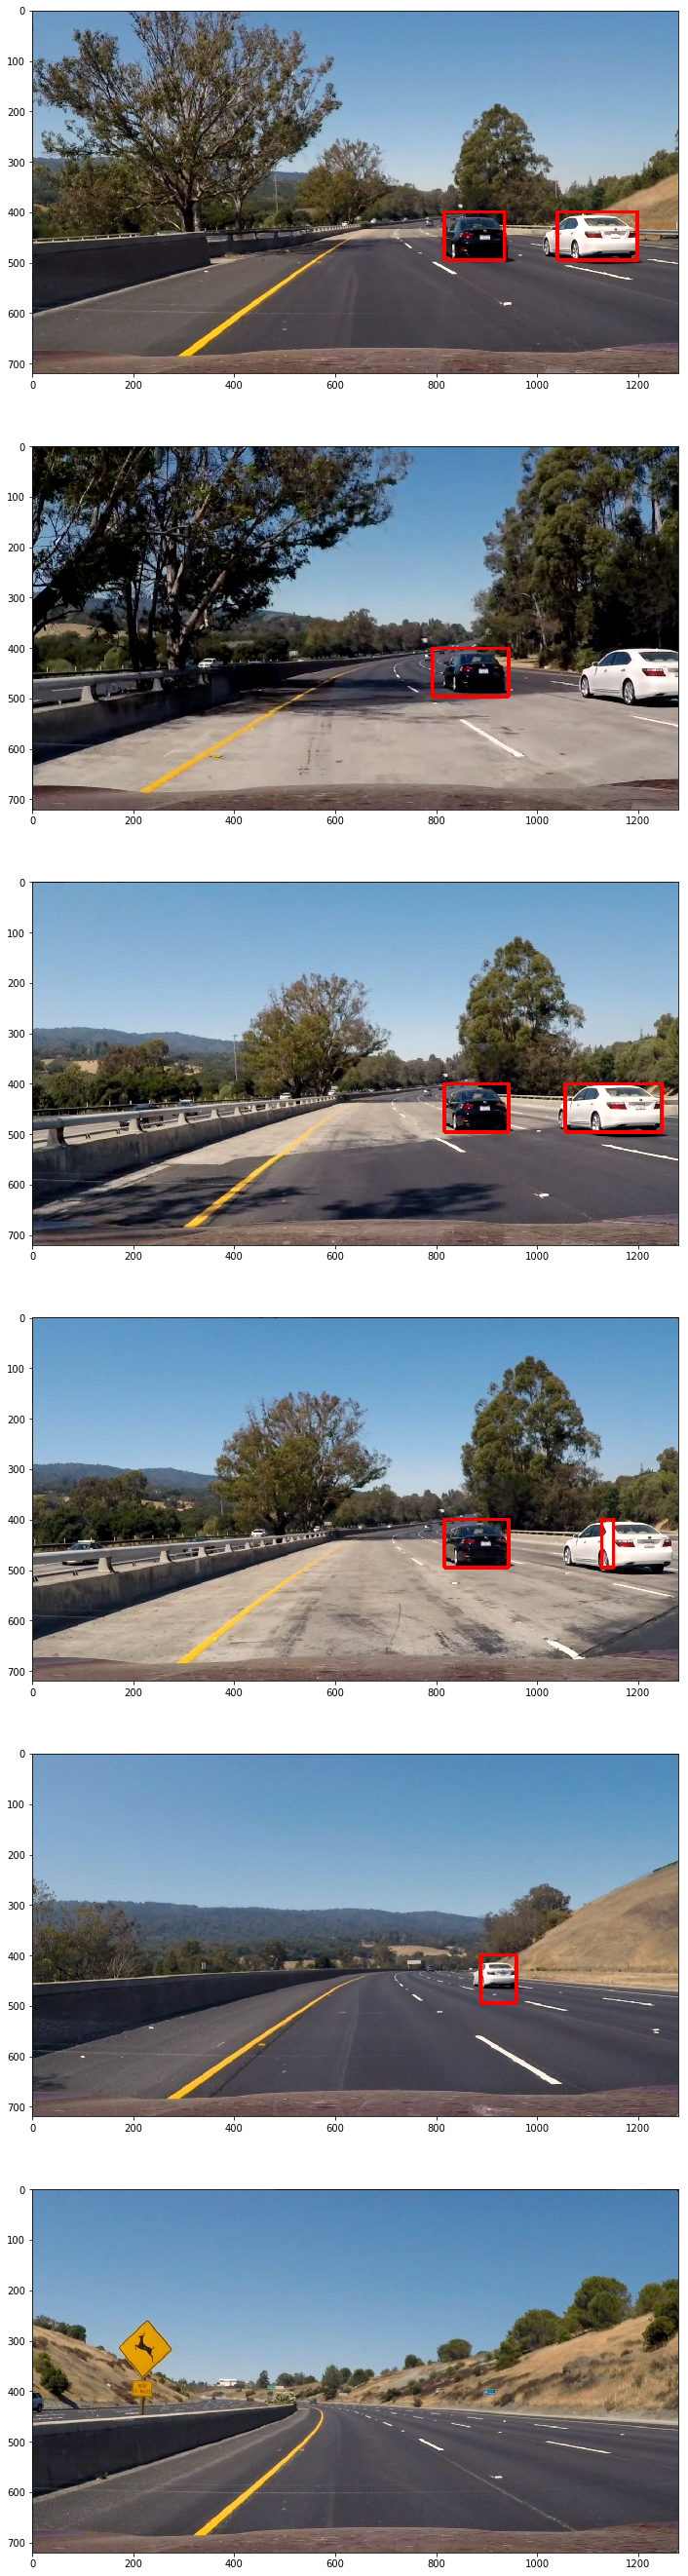

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

images = glob.glob('./test_images/*.jpg')

plt.figure(figsize=(36, 48))

num = len(images)
i = 1

y_start_stop = [400, 650]

for fname in images:
    img = mpimg.imread(fname)
    
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(num, 1, i)
    
    #proc = process_image(img)
        
    t = time.time()
        
    out_img = process_image(img) / 255
    
    '''
    out_img = find_cars(img, scale, y_start_stop)
    '''
    plt.imshow(out_img)
    
    
    '''
    windows = slide_window(img, x_start_stop = [None, None], y_start_stop = y_start_stop, 
                        xy_window=(96, 96), xy_overlap = (0.5, 0.5))
    
    hot_windows = search_windows(img)
    
    window_img = draw_boxes(img, hot_windows, color= (1, 0, 0), thick=6)                    
    plt.imshow(window_img)
    '''
    
    t2 = time.time()
    print(round(t2 - t, 2), 'Seconds to classify image...')

    #plt.imshow(proc, cmap='gray')

    i += 1

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [22]:
write_output = 'test_videos_output/test_19_all_4.mp4'

##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
#clip1 = VideoFileClip("./project_video.mp4").subclip(20, 20.5)
clip1 = VideoFileClip("./project_video.mp4")
#clip1 = VideoFileClip("./project_video.mp4").subclip(41, 50)

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/test_19_all_4.mp4
[MoviePy] Writing video test_videos_output/test_19_all_4.mp4


100%|█████████▉| 1260/1261 [17:21<00:00,  1.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/test_19_all_4.mp4 

CPU times: user 16min 51s, sys: 35.2 s, total: 17min 26s
Wall time: 17min 22s
